# Pulsations

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [2]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

The pulsations are represented as arrays of amplitude (percentage of the radius), which is calculated as a function of time. The user passes in parameters for the Fourier series representing this function:

$A = D + \sum_{n=1}^N cos(\frac{n}{P}t_n-\phi_n)$

In [3]:
m = IcosphereModel.construct(10000, 1., 1.,
                             bb.to_parameters(), bb.parameter_names)
m = add_pulsation(m, jnp.array([0, 0]), 1., jnp.array([[1e-1, 0.]]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:222: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


As in the case of any modifications, we have to call the ```evaluate``` function to obtain meshes which have the modified parameters.

In [4]:
TIMESTAMPS = jnp.linspace(0., 2., 1000)
mps = [evaluate_pulsations(m, t) for t in TIMESTAMPS]

## Spectrum emulation

Let's calculate the spectrum in a broad range of wavelengths.

In [5]:
vws = jnp.linspace(100., 40000., 1000)
specs = [simulate_observed_flux(bb.intensity, mp0, jnp.log10(vws)) for mp0 in tqdm(mps)]

100%|██████████| 1000/1000 [01:12<00:00, 13.83it/s]


We can inspect the spectrum changing over time.

Text(0, 0.5, 'Intensity [erg/s/cm$^2$/$\\AA$]')

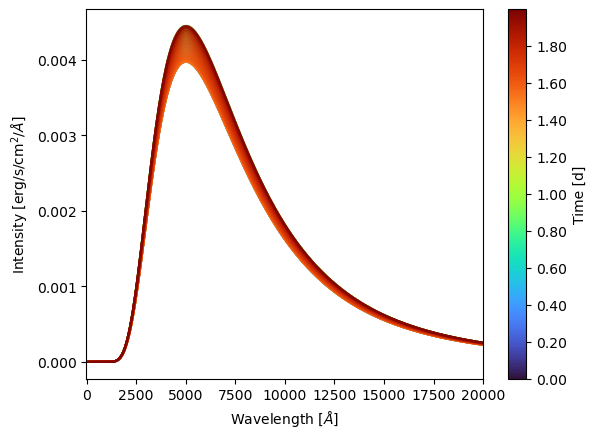

In [6]:
# Create a colormap based on the timestamps
cmap = plt.cm.turbo
norm = plt.Normalize(TIMESTAMPS.min(), TIMESTAMPS.max())
fig, ax = plt.subplots()

# Plot the spectra with colors corresponding to timestamps
for spec, timestamp in zip(specs[::10], TIMESTAMPS[::10]):
    ax.plot(vws, spec, color=cmap(norm(timestamp)), alpha=0.5)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work correctly
cbar = plt.colorbar(sm, ax=ax, ticks=TIMESTAMPS[::100])
cbar.set_label('Time [d]')

# Set the colorbar tick labels to the timestamp values
cbar.set_ticklabels([f'{t:.2f}' for t in TIMESTAMPS[::100]])

plt.gca().set_xlim(-10, 20000)
plt.gca().set_xlabel('Wavelength [$\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^2$/$\AA$]')

As well as create an animation with spectra and mesh.

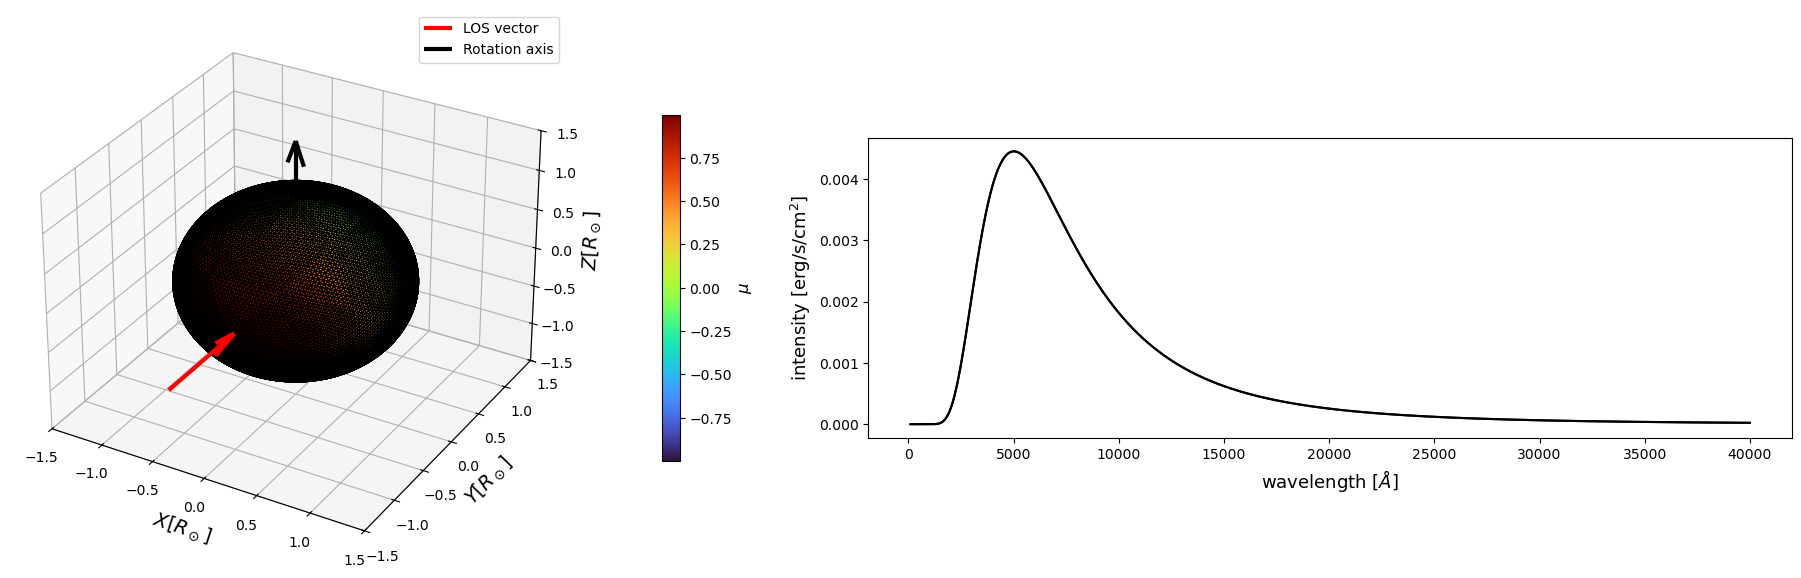

In [7]:
plot_3D_mesh_and_spectrum(mps[0], vws, specs[0]);

## Photometric time series

In [8]:
from spice.spectrum.filter import BesselU, BesselB, BesselV, Bolometric, GaiaG
from spice.spectrum.spectrum import AB_passband_luminosity, luminosity

Having synthetic spectra calculated, we can now calculate passband luminosities at $d=10$ pc.

In [9]:
luminosities = np.array([luminosity(bb.flux, mps1, vws) for mps1 in mps])

filters = [BesselU(), BesselB(), BesselV(), Bolometric(), GaiaG()]
passband_lums = [np.array([AB_passband_luminosity(f, vws, flux[:, 0]) for flux in specs]) for f in filters]

Let's compare that with the theoretical luminosity gain.

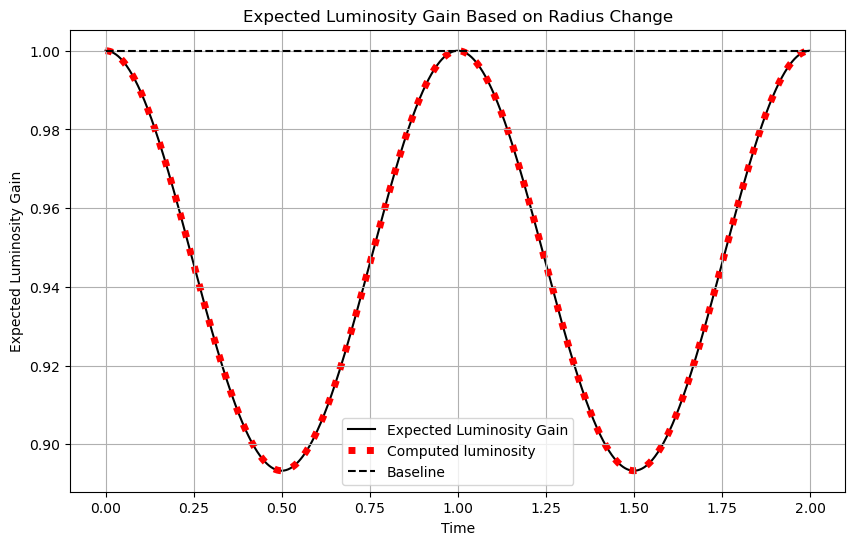

Max residual between expected luminosity gain and luminosities: 0.0000008941%


In [21]:
start_radius = jnp.mean(mps[0].radii)
mean_radii = np.array([jnp.mean(mps0.radii) for mps0 in mps])
expected_luminosity_gain = [(radius / start_radius)**2 for radius in mean_radii]

plt.figure(figsize=(10, 6))
plt.plot(TIMESTAMPS, expected_luminosity_gain, color='black', zorder=0, label='Expected Luminosity Gain')
plt.plot(TIMESTAMPS, (luminosities/jnp.max(luminosities)), color='red', linestyle='dotted', linewidth=5., zorder=1, label='Computed luminosity')

plt.plot(TIMESTAMPS, [1] * len(TIMESTAMPS), 'k--', label='Baseline')
plt.xlabel('Time')
plt.ylabel('Expected Luminosity Gain')
plt.title('Expected Luminosity Gain Based on Radius Change')
plt.legend()
plt.grid(True)
plt.show()

max_luminosity_gain = max(np.abs(np.array(expected_luminosity_gain)-(luminosities/jnp.max(luminosities))))
print(f"Max residual between expected luminosity gain and luminosities: {max_luminosity_gain:.10f}%")

We can also calculate color indices based on the synthetic photometry.

In [22]:
U_phot, B_phot, V_phot, bolometric, G_phot = passband_lums

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


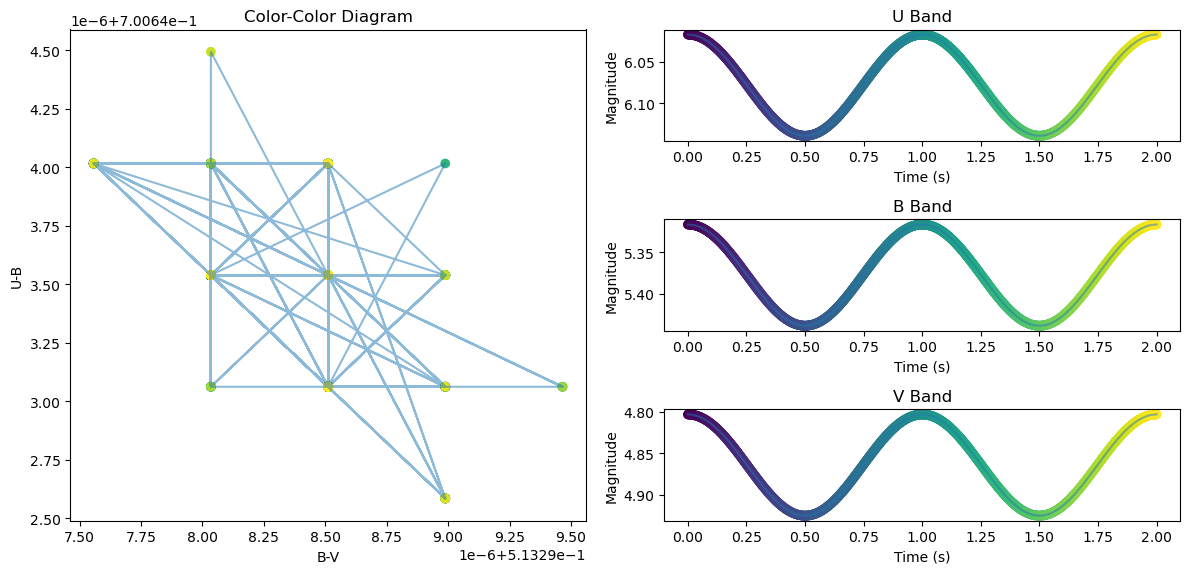

In [23]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5)
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='viridis')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='viridis', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()

The color does barely change (the tiny changes are the result of Doppler shifts causing some of the intensity to "fall outside" of the filters), as expected from the temperature-insensitive toy model we employed. In reality, the temperature will change while the star is pulsating, so this is a highly unrealistic case.

# Frequency analysis

Lastly, let's perform a frequency analysis to recover the pulsation period from the synthetic photometry timeseries.

In [24]:
TIMESTAMPS_LONG = np.linspace(0, 100, 1000)

mps_long = [evaluate_pulsations(m, t) for t in TIMESTAMPS_LONG]
specs_long = [simulate_observed_flux(bb.intensity, mp0, jnp.log10(vws)) for mp0 in tqdm(mps_long)]

U_phot_long, B_phot_long, V_phot_long, bolometric_long, G_phot_long = [np.array([AB_passband_luminosity(f, vws, flux[:, 0]) for flux in specs_long]) for f in filters]

# Calculate color indices for the longer timeseries
U_B_long = U_phot_long - B_phot_long
B_V_long = B_phot_long - V_phot_long

In [ ]:
from astropy.timeseries import LombScargle

frequency = np.linspace(1/25, 5, 10000)
power = LombScargle(TIMESTAMPS_LONG[10:], U_phot_long[10:]).power(frequency)

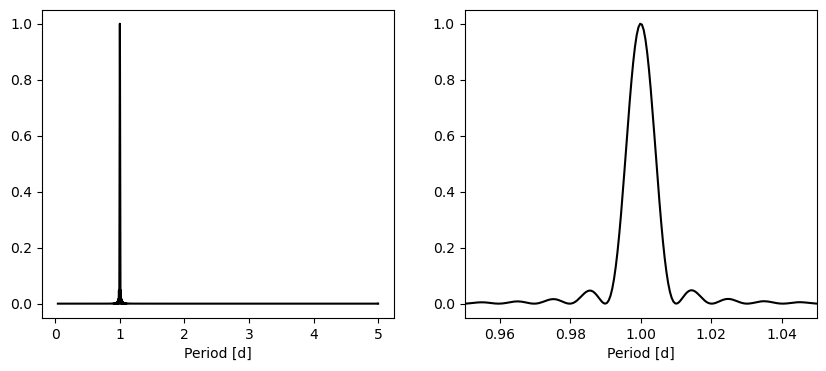

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].plot(frequency, power, color='black');
ax[0].set_xlabel('Period [d]');
ax[1].plot(frequency, power, color='black');
ax[1].set_xlabel('Period [d]');
ax[1].set_xlim(0.95, 1.05);

In [ ]:
1/frequency[np.argmax(power)]

1.0001440351445754